## 章節 6：決策分析（Dicision Analysis）

### 6.8 最佳出價

現在我們有了一個後驗分佈，可以用它計算最佳出價。這邊用做大化預期回報（exptected return）作為指標找出最佳出價。（http://en.wikipedia.org/wiki/Expected_return)

這面會用由上而下（top-down）的方式來介紹，也就是先說明怎麼用，再來說明怎麼做。如果你看到不熟悉的方法，不用擔心；定義等等就會說明。

為了計算最佳出價，撰寫了一個 GainCalculator 類別。

GainCalculator 類別提供 ExpectedGains 方法來計算一連串猜測價格的回報。

<pre>
class GainCalculator(object):
    
    def __init__(self, player, opponent):
        # player: 一個 Player 物件
        # opponent: 也是一個 Player 物件
        self.player = player
        self.opponent = opponent
        
    def ExpectedGains(self, low=0, high=75000, n=101):
        # low：猜測的最低價格
        # high：猜測的最高價格
        # n：猜測的次數
        bids = numpy.linspace(low, high, n)
        gains = [self.ExpectedGain(bid) for bid in bids]
        return bids, gains
</pre>

ExpectedGains 方法呼叫 ExpectedGain 方法，此方法會計算針對某一猜測價格其預期回報。
ExpectedGain 針對後驗分佈的每個價格針對猜測價格計算回報。對每一回報依據價格的機率作為比重並加總作為總回報。

<pre>
   def ExpectedGain(self, bid):
        suite = self.player.posterior
        total = 0
        for price, prob in sorted(suite.Items()): # 計算期望回報
            gain = self.Gain(bid, price)
            total += prob*gain
        
        return total
</pre>

ExpectedGain 方法呼叫 Gain 方法，此方法會回傳計算出價跟實際價格的預期回報。

<pre>
def Gain(self, bid, price):

    if bid > price: # 出價比實際價格高則回報為 0
        return 0
    
    diff = price - bid
    prob = self.ProbWin(diff) # 用價差計算贏對手的機率
    
    if diff &lt;=250: # 根據遊戲規則，若價差小於 250 元則同時贏到展示品1跟展示品2
        return 2 * price * prob # 這邊假設展示品1跟展示品2的價格一樣
    else:
        return price * prob
        
</pre>

Gain 方法又呼叫 ProbWin 方法，根據價差回傳贏對手的機率。
考慮兩種情況：

1. 如果對手出價過高，則我們贏
2. 如果對手價差較多，則我們贏

<pre>
def ProbWin(self, diff):
    prob = (self.opponent.ProbOverbid() + # 對手出價過高的情況
            self.opponent.ProbWorseThan(diff)) # 對手價差比我的情況
    return prob
</pre>

Player 類別提供 ProbOverbid 方法跟 ProbWorseThan 方法。
<pre>
def ProbOverbid(self):
    return self.cdf_diff.Prob(-1)
    
    
def ProbWorseThan(self, diff):
    return 1 - self.cdf_diff.Prob(diff) # 1 - 比價差比 diff 小的機率 = 價差比 diff 大的機率
</pre>


這段程式碼可能令人困話，因為現在需要計算的觀點是來自於對手。他的觀點是：「我出價過高的機率是？」和「我價差更多的機率是？」

兩個問題的答案可用 diff 的 CDF 分佈來計算。

1. 對手出價過高的機率是？表示 diff 小於 -1 元的機率（至少出價比實際價格多 1 元）
2. 對手價差較多的機率是？表示 diff 的價差比你大的機率

最後計算給定一個猜測的價格和對手，OptimalBid 方法會計算最佳的出價與回報。

<pre>
# class Player:
def OptimalBid(self, guess, opponent):
    self.MakeBeliefs(guess) # 根據猜測價格計算後驗分佈
    calc = GainCalculator(self, opponent) # 初始化 GainGcalculator 物件
    bids, gains = calc.ExpectedGains() # 計算出價與回報的分佈
    gain, bid = max(zip(gains, bids)) # 計算最佳回報下的出價
    return bid, gain
</pre>

最後請看最下方程式碼執行結果所產生的圖形。

In [48]:
# 實作函數

from thinkbayes import Suite, EstimatedPdf, MakeCdfFromList, GaussianPdf, Pmf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



class GainCalculator(object):
    
    def __init__(self, player, opponent):
        # player: 一個 Player 物件
        # opponent: 也是一個 Player 物件
        self.player = player
        self.opponent = opponent
        
    def ExpectedGains(self, low=0, high=75000, n=101):
        # low：猜測的最低價格
        # high：猜測的最高價格
        # n：猜測的次數
        bids = np.linspace(low, high, n)
        gains = [self.ExpectedGain(bid) for bid in bids]
        return bids, gains
    
    
    def MyExpectedGain(self, bid):
        self.player.Update(bid)
        return self.player.posterior.Mean() - bid

    
    def ExpectedGain(self, bid):
        suite = self.player.posterior
        total = 0
        for price, prob in sorted(suite.Items()): # 計算期望回報
            gain = self.Gain(bid, price)
            total += prob*gain
        
        return total
    
    
    def Gain(self, bid, price):
        if bid > price:
            return 0
        
        diff = price - bid
        prob = self.ProbWin(diff)
        
        if diff <= 250:
            return 2 * price * prob
        else:
            return price * prob

        
    def ProbWin(self, diff):
        prob = (self.opponent.ProbOverbid() +
        self.opponent.ProbWorseThan(diff))
        return prob


class Player(object):
    
    n = 101 # 取樣點數
    price_xs = np.linspace(0, 75000, n) # 價格範圍
    
    def __init__(self, prices, bids, diffs):
        # prices: 真實價格的序列
        # bids: 參賽者出價的序列
        # diffs: 價差的序列
        
        # 平滑化版本的真實價格分佈(先驗分佈)
        self.pdf_price = EstimatedPdf(prices)
        
        # diff 的累積機率分佈，如上圖的 CDF
        self.cdf_diff = MakeCdfFromList(diffs)
        
        mu = 0
        sigma = np.std(diffs)
        
        # 價差的高斯分佈（似然性）
        self.pdf_error = GaussianPdf(mu, sigma)
    
    
    def ProbOverbid(self):
        return self.cdf_diff.Prob(-1)
    
    
    def ProbWorseThan(self, diff):
        return 1 - self.cdf_diff.Prob(diff)
    
    
    def MakeBeliefs(self, guess):
        pmf = self.PmfPrice() # 產生價格的近似分佈
        self.prior = Price(pmf, self) # 價格先驗分佈
        self.posterior = self.prior.Copy() # 複製價格先驗分佈
        self.posterior.Update(guess) # 更新分佈
        
        
    def PmfPrice(self): # 價格的近似分佈
        return self.pdf_price.MakePmf(self.price_xs)
    
    
    def ErrorDensity(self, error):
        return self.pdf_error.Density(error) # 計算 error 的機率密度
    
    def BidGainDist(self, guess, opponent):
        self.MakeBeliefs(guess)
        calc = GainCalculator(self, opponent)
        return calc.ExpectedGains()
    
    def OptimalBid(self, guess, opponent):
        bids, gains = self.BidGainDist(guess, opponent)
        gain, bid = max(zip(gains, bids))
        return bid, gain


class Price(Suite):
    
    def __init__(self, pmf, player):
        # pmf：先驗分佈
        # player：player 物件
        super().__init__(pmf)
        self.player = player 
        
    def Likelihood(self, data, hypo):
        price = hypo # 假設展示品的真實價格為 price
        guess = data # 參賽者在給定 price 下最好的出價價格
        error = price - guess
        like  = self.player.ErrorDensity(error) # 似然性計算
        return like

    
def plot_pmf(pmf):
    x, y = zip(*sorted(pmf.Items()))
    plt.plot(x, y)


def simple_read_col(file, col_name):
    df = pd.read_csv(file, index_col=0).T
    return df[col_name].astype(int).values

    
def simple_read_prices(file, showcase=1):
    col_name = "Showcase %d" % showcase        
    return simple_read_col(file, col_name)


def get_all_prices(showcase=1): # 先不考慮效率
    data = ["showcases.2011.csv", "showcases.2012.csv"]
    return np.concatenate([simple_read_prices(file, showcase) for file in data])


def simple_read_diff(file, showcase=1):
    col_name = "Difference %d" % showcase        
    return simple_read_col(file, col_name)
    
    
def get_all_diff(showcase=1): # 先不考慮效率
    data = ["showcases.2011.csv", "showcases.2012.csv"]
    return np.concatenate([simple_read_diff(file, showcase) for file in data])


def simple_read_bid(file, showcase=1):
    col_name = "Bid %d" % showcase        
    return simple_read_col(file, col_name)
    
    
def get_all_bid(showcase=1): # 先不考慮效率
    data = ["showcases.2011.csv", "showcases.2012.csv"]
    return np.concatenate([simple_read_bid(file, showcase) for file in data])


def make_pmf(data):
    pdf = EstimatedPdf(data)
    low, high = -30000, 50000
    n = 1001
    xs = np.linspace(low, high, n)
    pmf = pdf.MakePmf(xs)
    return pmf


def plot_kde_prices(showcase=1):
    prices = get_all_prices(showcase)
    print("展示品", showcase, "價格總數", prices.size, "比")
    pdf = EstimatedPdf(prices)

    low, high = 0, 75000
    n = 101
    xs = np.linspace(low, high, n)
    pmf = pdf.MakePmf(xs)
    plot_pmf(pmf)

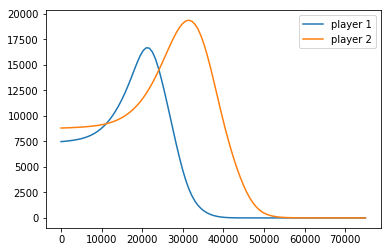

參賽者1 最佳的出價以及最大回報： (21000.0, 16668.78146356438)
參賽者2 最佳的出價以及最大回報： (31500.0, 19365.953590885674)


In [49]:
# 模擬問題情境

p1_data = [get_all_prices(1), get_all_bid(1), get_all_diff(1)]
p2_data = [get_all_prices(2), get_all_bid(2), get_all_diff(2)]
player1 = Player(*p1_data)
player2 = Player(*p2_data)

p1_guess = 20000
p2_guess = 40000

def plot_bid_gains_dist(player, bid, opponent):
    bids, gains = player.BidGainDist(bid, opponent)
    plt.plot(bids, gains)
 
plot_bid_gains_dist(player1, p1_guess, player2)
plot_bid_gains_dist(player2, p2_guess, player1)
plt.legend(["player 1", "player 2"])
plt.show()

print("參賽者1 最佳的出價以及最大回報：", player1.OptimalBid(p1_guess, player2))
print("參賽者2 最佳的出價以及最大回報：", player2.OptimalBid(p2_guess, player1))

上圖為兩個參賽者在互為對手的情況下，出價跟回報的分佈。

參賽者1 猜測的價格是 20000 美元，經過模型分析後，對參賽者1 來說最佳的出價是 21000 美元，回報約為 16700 美元。這個例子是最佳出價的價格要高於參賽者的猜測（這種情況相對少見）。

參賽者2 猜測的價格是 40000 美元，經過模型分析後，對參賽者2 來說最佳的出價是 31500 美元，回報約為 19400 美元。這種最佳出價比猜測價格低是比較常見的例子。